In [3]:
import numpy as np 
import pandas as pd
import os,re
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.lines import Line2D

In [4]:
import numpy as np 
import pandas as pd
import os,re
import nimfa
from sklearn.decomposition import NMF
from collections import defaultdict

class probiotics_signature :

    def __init__(self,metadata,abundance_matrix) :
        """
        Init a probiotics signature object.

        Args:
            metadata (pd.Dataframe): clinical information or demographic data of patients / participants. row is sample, column is condition.
            abundance_matrix (pd.Dataframe): patient abundance matrix. row is species, column is sample.
        """        
        self.sample_metadata = None
        self.abundance_matrix = None

    def species_abundance_prevelence_scatterplot(self,input_matrix,output_path,format='pdf') :
        """
        Scatterplot of target species abundance / prevalence

        Args:
            input_matrix (pd.DataFrame): Target abundance matrix. row is species, column is sample.
            output_path (str): Output path of scatterplot.
            format (str, optional): Output figure format. Defaults to 'pdf'.
        """               
        mean_abundance = self.abundance_matrix.mean(axis=1)
        prevalence = self.abundance_matrix.apply(lambda x : (sum(x > 0)/len(x))*100,axis=1)
        plot_df = pd.DataFrame({'Prevalence' : prevalence,
                                'Mean_abundance' : mean_abundance,
                                'Species' : list(self.abundance_matrix.index)})

        plt.figure(figsize=(7,5))
        sns.scatterplot(data=plot_df,x='Prevalence',y='Mean_abundance',hue='Species',palette="rainbow_r",s=100)
        plt.xlabel("Prevalence(%)")
        plt.ylabel("Mean relative abundance(%)")
        plt.legend(bbox_to_anchor=[1,1],ncol=2,title="Species")
        plt.savefig(output_path,format=format,dpi=300,bbox_inches='tight')

    def concat_species_into_subtype(self,input_matrix,reference_df,genus='Lactobacillus',species_colname='species',subtype_colname='phylogroup') :
        """
         Merge abundance from rate species into subtype. (ex : Lactobacillus genus)

        Args:
            input_matrix (pd.DataFrame): Target abundance matrix. row is species, column is sample. The format of input matrix index must be Lactobacillus_acidophilus.
            reference_df (pd.DataFrame): Table with subtype information. Please make sure the format of species column is identical to input matrix index.
            species_colname (str, optional): Colname of species in reference_df. Defaults to 'species'.
            subtype_colname (str, optional): Colname of subtype in reference_df. Defaults to 'phylogroup'.

        Returns:
            subtype_matrix (pd.DataFrame): Abundance matrix of each subtype.
            subtype_dict (dict) : Dict of subtype and its components. Key is subtype, value is list of species
        """         
        speceis2subtype = dict(zip([x.replace(' ','_') for x in reference_df['species'].values],subtype_reference[subtype_colname].values))
        subtype_dict = defaultdict(list) 
        # subtype_dict format like : {'Levilactobacillus' : ['Lactobacillus_acetotolerans','Lactobacillus_acidophilus']}
        for species in input_matrix.index :
            if species in speceis2subtype :
                subtype = speceis2subtype[species]
            else :
                subtype = 'no phylogroup'

            if subtype == 'no phylogroup' :
                subtype_dict[genus + '_others'].append(species)
            else :
                subtype_dict[subtype+'_subtype'].append(species)

        subtype_matrix = pd.DataFrame(np.zeros([len(subtype_dict),input_matrix.shape[1]]),
        index = list(subtype_dict.keys()),columns=input_matrix.columns)
        for subtype in subtype_dict :
            target_species = list(set(subtype_dict[subtype]).intersection(input_matrix.index))
            subtype_matrix.loc[subtype,:] = input_matrix.loc[target_species,:].sum()

        return subtype_matrix,subtype_dict   

    def evaluate_nmf_component(self,input_matrix,min_k=2,max_k=10) :
        """
        Evaluate optimal k component for NMF decomposition processing.

        Args:
            input_matrix (numpy.ndarray) : The original matrix for NNF (V).
            k_min (int, optional): The minimum component number. Defaults to 2.
            k_max (int, optional): The maximum component number. Defaults to 10.
        """        
        nmf = nimfa.Nmf(input_matrix,rank=max_k, max_iter=200)
        nmf_fit = nmf()
        #evaluation
        rank_list = list(range(min_k,max_k+1))
        evalation = nmf.estimate_rank(rank_range=[x for x in rank_list],n_run=100)
        #output the estimation result
        measurements = ['rss','evar','dispersion','cophenetic','kl']
        measurement_table = pd.DataFrame({'Rank' : rank_list})
        for m in measurements :
            measurement_table[m] = [evalation[x][m] for x in rank_list]
        return measurement_table

    def plot_nmf_rank(self,measurement_table,
                    measurement_1 = 'cophenetic',
                    measurement_2 = 'rss',
                    fig_output_path='nmf_evaluation.pdf',
                    fig_format='pdf') :
        """
        Visualation of NMF rank evaluation.

        Args:
            measurement_table (pd.DataFrame): The measurement result, including Rank, rss, evar, dispersion, cophenetic, kl.
            measurement_1 (str, optional): The first measurement of NMF rank. Defaults to 'cophenetic'.
            measurement_2 (str, optional): The second measurement of NMF rank. Defaults to 'rss'.
            fig_output_path (str, optional): The figure output path. Defaults to 'nmf_evaluation.pdf'.
            fig_format (str, optional): The figure output format. Defaults to 'pdf'.
        """  
        if measurement_1 not in measurement_table.columns :
            print("Please confirm %s in measurement table !" % measurement_1)
            return 
        if measurement_2 not in measurement_table.columns :
            print("Please confirm %s in measurement table !" % measurement_2)
            return

        plt.figure(figsize=(8,5))
        g = sns.lineplot(data=measurement_table,x ='Rank',y=measurement_1, color="orange",marker='o')
        sns.lineplot(data=measurement_table,x = 'Rank',y=measurement_2, ax=g.axes.twinx(),marker='o')
        g.legend(handles=[Line2D([], [], marker='o', color="orange", label=measurement_1), 
                        Line2D([], [], marker='o', label=measurement_2)])
        plt.savefig(fig_output_path,dpi=300,format=fig_format)

    def finger_print_proportion(self,x,w,h):
        """
        Calculate the contribution of each NMF decompose component.
        Args:
            x (np.array): The original matrix.
            w (np.array): The weight matrix of NMF decomposition.
            h (np.array): The coefficient matrix of NMF decomposition

        Returns:
            proportion_matrix (np.array): The contribution of each component.
        """        
        n_finger_print = w.shape[1]
        n_sample = w.shape[0]
        proportion_matrix = np.zeros([n_sample,n_finger_print])

        for i in range(n_sample) :
            total = sum(x[i,:])
            if total == 0 :
                continue
            else :
                for j in range(n_finger_print) :
                    ab = sum(np.dot(w[i,j],h[j,:]))# type: ignore       
                    proportion_matrix[i,j] = ab / total
        return proportion_matrix

    def sklearn_decompose_probiotics_signature(self,input_matrix,k,prefix) :
        """
        Decompose k signatures from input abundance matrix.

        Args:
            input_matrix (pd.DataFrame) : The origin matrix (n_species * n_sample) to be decomposed. 
            k (int): Number of component expected to be decomposed.
        """        
        X = input_matrix.T.to_numpy() # n_sample * n_species
        #sklearn.decomposition version
        nmf_model = NMF(n_components=k, init='random', random_state=0,max_iter=1000)
        nmf_model.fit(X)
        W = nmf_model.transform(X) # n_sample * n_component
        H = nmf_model.components_ # n_component * n_species

        finger_print_matrix = self.finger_print_proportion(X,W,H) # n_sample * n_component
        index = [prefix + ' signature' + str(x) for x in range(1,k+1)]
        # format signature coefficient matrix (n_component * n_species)
        sig_coefficient = pd.DataFrame(H.T,index=input_matrix.index,columns=index) 
        # format signature weight matrix (n_component * n_sample)
        finger_print_df = pd.DataFrame(finger_print_matrix.T,index=index,columns=input_matrix.columns)
        finger_print_df[finger_print_df > 1] = 1
        finger_print_df[finger_print_df < 0] = 0

        return finger_print_df,sig_coefficient

    def nimfa_decompose_probiotics_signature(self,input_matrix,k,prefix) :
        """
        Decompose k signatures from input abundance matrix.

        Args:
            input_matrix (pd.DataFrame) : The origin matrix (n_species * n_sample) to be decomposed. 
            k (int): Number of component expected to be decomposed.
        """        
        X = input_matrix.T.to_numpy() # n_sample * n_species
        #Nimfa version
        nmf_model = nimfa.Nmf(X,rank=k, max_iter=1000)
        nmf_fit = nmf_model()
        W = np.array(nmf_fit.basis()) # n_sample * n_component
        H = np.array(nmf_fit.coef()) # n_component * n_species
        
        finger_print_matrix = self.finger_print_proportion(X,W,H) # n_sample * n_component
        index = [prefix + ' signature' + str(x) for x in range(1,k+1)]
        # format signature coefficient matrix (n_component * n_species)
        sig_coefficient = pd.DataFrame(H.T,index=input_matrix.index,columns=index) 
        # format signature weight matrix (n_component * n_sample)
        finger_print_df = pd.DataFrame(finger_print_matrix.T,index=index,columns=input_matrix.columns)
        finger_print_df[finger_print_df > 1] = 1
        finger_print_df[finger_print_df < 0] = 0

        return finger_print_df,sig_coefficient

### initialization & load requirement

In [5]:
abundance_matrix = pd.read_csv("/home/bruce1996/data/MCI/metaphlan_result/metaphlan_format_table.txt",sep='\t',index_col=0)
metadata = pd.read_csv("/home/bruce1996/data/MCI/metadata/metadata_20221224.csv",sep=',',index_col=0)
distance_matrix = pd.read_csv("/home/bruce1996/data/MCI/metaphlan_result/latest_unweighted_unifrac_distance_matrix.txt",sep='\t',index_col=0)
subtype_reference = pd.read_csv("/home/bruce1996/data/MCI/subtyping/Lactobacillus_group.csv")
ps = probiotics_signature(abundance_matrix=abundance_matrix,metadata=metadata)

In [6]:
# lactobacillus subtype
lacto_m = abundance_matrix.loc[[bool(re.search("Lactobacillus",x)) for x in abundance_matrix.index],:]
lacto_m.index = [x[3:] for x in lacto_m.index]
subtype_matrix,subtype_dict = ps.concat_species_into_subtype(lacto_m,subtype_reference)
# extract bifido bacterium 
bifido_m = abundance_matrix.loc[[bool(re.search("Bifidobacterium",x)) for x in abundance_matrix.index],:]
bifido_m.index = [x[3:] for x in bifido_m.index]

### Evaluate & decompose optimal k of NMF

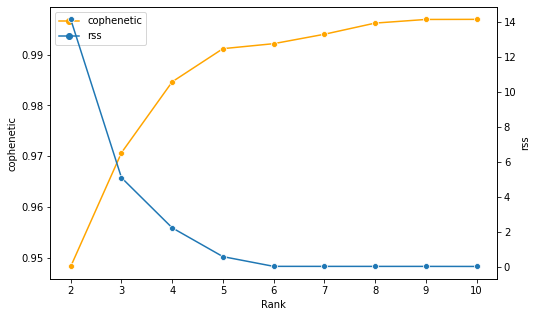

In [101]:
measure_df = ps.evaluate_nmf_component(subtype_matrix.to_numpy())
ps.plot_nmf_rank(measure_df)

In [7]:
lacto_proportion_matrix, lacto_coef_matrix = ps.nimfa_decompose_probiotics_signature(subtype_matrix,k=3,prefix='Lactobacillus')
bifido_proportion_matrix, bifido_coef_matrix = ps.nimfa_decompose_probiotics_signature(bifido_m,k=3,prefix='Bifidobacterium')

### Visualization of probiotics signature

In [8]:
import numpy as np  
import pandas as pd
from math import log10
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm,colors
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import plotly.express as px
import plotly.io as pio
from itertools import combinations
from skbio.stats.ordination import pcoa # type: ignore
from skbio.stats.distance import permanova,DistanceMatrix# type: ignore
from sklearn.manifold import MDS

In [11]:
class probiotics_signature_visualizer :
    def __init__(self,signature_proportion_matrix,sig_coefficient_matrix,sample_distance_matrix,sample_metadata) :
        """
        Visualziation of probiotics signature result

        Args :
        signature_proportion_matrix (pd.Dataframe): n_signature * n_samples. The value of matrix represent the proportion of abundance contributed by signature in samples.
        sig_coefficient_matrix (pd.Dataframe): n_signature * n_species. The value of matrix represent the coefficient of NMF W matrix.
        metadata (pd.Dataframe):
        distance_matrix (pd.Dataframe): n_sample * n_sample distance matrix. The value inside the matrix is the distance between samples. 
            (ex : Unifrac / Bray-curtis distance)
        """        
        self.signature_proportion_matrix = signature_proportion_matrix
        self.sig_coefficient_matrix = sig_coefficient_matrix
        self.distance_matrix = sample_distance_matrix
        self.metadata = sample_metadata
        
    def plot_signature_relative_importance_stacked_barplot(self,output_path,output_prefix,
                                                      palette = px.colors.qualitative.Pastel,
                                                      fig_format='pdf',legend_title = 'Species',
                                                      xlabel = 'Relative importantance') :
        """
        Visualization of signature relative importance. (via Plotly)

        Args:
            output_path (str): The path of output folder.
            output_prefix (str): The prefix of output figure. ex : ${output_prefix}_signature_composition_barplot.png
            palette (_type_, optional): The colormap of stacked barplot. Defaults to px.colors.qualitative.Pastel.
            fig_format (str, optional): The format of output figure. Defaults to 'pdf'.
            legend_title (str, optional): The legend title of output figure. Defaults to 'Species'.
            xlabel (str, optional): The xlabel of stacked barplot. Defaults to 'Relative importantance'.
        """                                                            

        sig_coef_matrix = self.sig_coefficient_matrix #n_species * n_component
        sig_coef_matrix.columns = [x.capitalize() for x in sig_coef_matrix.columns]
        plot_df = pd.DataFrame()
        plot_df['Species'] = [x.replace('_',' ') for x in sig_coef_matrix.index]
        # Calculate relative importance of each species
        for c in sig_coef_matrix.columns :
            #relative_importance = [100 * x / sum(log_relative_coef) for x in log_relative_coef]
            relative_coef = sig_coef_matrix[c].transform(lambda x: 100 * x/x.sum()).values
            log_relative_coef = list(map(lambda x : log10(x+1),relative_coef))
            plot_df[c] = log_relative_coef
        
        plot_df = plot_df.melt(id_vars='Species')
        plot_df['Species'] = [x.capitalize() for x in plot_df['Species'].values]  # type: ignore
        # arrange legend & bar order 
        legend_order = np.unique(plot_df['variable'])
        bar_order = np.unique(plot_df['Species'])
        fig = px.bar(plot_df, x="value", y="variable", color="Species",width=1200, height=500,template='simple_white',
                    color_discrete_sequence=palette,category_orders={"variable": legend_order},labels={'value' : xlabel})
        fig.update_layout(barmode='stack', xaxis={'categoryorder':'array','categoryarray':bar_order}, title_x=0.5,yaxis_title=None,legend={'title' : legend_title})
        #output plotly fig object to figure
        pio.write_image(fig,output_path + output_prefix + '_' +'signature_composition_barplot'  + '.' + fig_format,format = fig_format,scale = 2)
        fig.show() 

    def plot_signature_relative_importance_barplot(self,output_path,
                                                    xlabel = 'Species',xticks = None,
                                                    fig_format = 'pdf',cmap = 'Set3',fig_size = (7,3)) :
        """
        Visualization of signature relative importance

        Args:
            output_path (str): The output folder path. 
            xlabel (str, optional): The label of x-axis. Defaults to 'Species'.
            xticks (_type_, optional): The ticks of x-axis. Defaults to None.
            fig_format (str, optional): Figure output format. Defaults to 'pdf'.
            cmap (str, optional): The colormap of barplot. Defaults to 'Set3'.
            fig_size (tuple, optional): _description_. Defaults to (7,3).
        """        

        plot_df = self.sig_coefficient_matrix.copy() #n_species * n_component
        for c in plot_df.columns :
            relative_coef = plot_df[c].transform(lambda x: 100 * x/x.sum()).values
            log_relative_coef = list(map(lambda x : log10(x+1),relative_coef))
            plot_df[c] = log_relative_coef
        # plot setting
        n_element = plot_df.shape[0]
        plot_df['Species'] = list(plot_df.index)
        # plot barplot
        for c in plot_df.columns[:-1] :
            plt.figure(figsize=fig_size)
            sns.barplot(data=plot_df,y=c,x='Species',palette=cmap)
            plt.title(c.capitalize())
            # If signature not the last signature, don't show the xtick & label
            if c != plot_df.columns[-2] :
                plt.xticks([])
                plt.xlabel('')
                plt.ylabel('')
            else :
                if not xticks :
                    xticks = list(plot_df.index)
                x = np.arange(n_element)
                plt.xticks(x,xticks,rotation=90)
                plt.xlabel(xlabel)
                plt.ylabel('')
            plt.savefig("%s%s_sig_relative_importance_barplot.%s" % (output_path,c.replace(' ','_'),fig_format),dpi=300,format=fig_format)
            plt.show()

    def plot_signature_relative_importance_heatmap(self,colorbar_col,sample_order,legend_title,output,format = 'pdf') :
        """
        Args:
            colorbar_col (list): colnames of label_df will treat as colorbar, it can be one or two columns.
            sample_order (list) : Specific sample order list.
            legend_title (str): title of the heatmap legend.
            output (str): Output path of the heatmap.
            format (str, optional): . Defaults to 'pdf'.
        """  
        try :
            metadata_df = self.metadata.loc[sample_order,:].copy()
            plot_df = self.signature_proportion_matrix.loc[:,sample_order].T.copy()
        except :
            print("Please make sure the sample order is identical of in sig matrix")
            return 
        cmap = sns.light_palette("darksalmon", as_cmap=True)
        #convert cluster dtype from int -> str
        cluster1 = metadata_df[colorbar_col[0]].astype(str).values
        cluster1_lut = dict(zip( set(cluster1),  [cm.Set2(x) for x in range(10)] )) # type: ignore
        cluster1_colors = pd.Series(cluster1).map(cluster1_lut)
        cluster1_colors.index = metadata_df.index

        if len(colorbar_col) == 1 :
        
            g = sns.clustermap(plot_df, cmap=cmap,vmin=0, vmax=1,  cbar_kws={"shrink": .3},
                        row_cluster=False, 
                        col_cluster=False,
                        row_colors=[cluster1_colors[plot_df.index]],
                        linewidths=0, figsize=(6,10))
            g.ax_cbar.set_position((0.05, .3, .03, .4))# type: ignore
            g.cax.set_title("Sig proportion",fontsize = 10)# type: ignore

            for label in sorted(set(cluster1)):
                g.ax_col_dendrogram.bar(0, 0, color=cluster1_lut[label], label=label, linewidth=0.5)
            l1 = g.ax_col_dendrogram.legend(title=legend_title, loc="center", ncol=len(set(cluster1)), bbox_to_anchor=(0.5, .9), bbox_transform=plt.gcf().transFigure) # type: ignore
        else :

            cluster2 = metadata_df.loc[:,colorbar_col[1]].astype(str).values
            cluster2_lut = dict(zip( set(cluster2),  [cm.Set3(x) for x in range(10)] ))# type: ignore
            cluster2_colors = pd.Series(cluster2).map(cluster2_lut)
            cluster2_colors.index = metadata_df.index

            cmap = sns.light_palette("darksalmon", as_cmap=True)

            g = sns.clustermap(plot_df, cmap=cmap,vmin=0, vmax=1,  cbar_kws={"shrink": .3},
                            row_cluster=False, 
                            col_cluster=False,
                            row_colors=[cluster1_colors[plot_df.index],cluster2_colors[plot_df.index]],
                            linewidths=0, figsize=(6,10))
            g.ax_cbar.set_position((0.05, .3, .03, .4))# type: ignore
            g.cax.set_title("Sig proportion",fontsize = 10)# type: ignore
            
            for label in sorted(set(cluster1)):
                g.ax_col_dendrogram.bar(0, 0, color=cluster1_lut[label], label=label, linewidth=0)
            l1 = g.ax_col_dendrogram.legend(title=colorbar[0], loc="center", ncol=5, bbox_to_anchor=(0.5, .95), bbox_transform=plt.gcf().transFigure) # type: ignore
        
            for label in sorted(set(cluster2)):
                g.ax_row_dendrogram.bar(0, 0, color=cluster2_lut[label], label=label, linewidth=0)
            l2 = g.ax_row_dendrogram.legend(title=colorbar[1], loc="center", ncol=5, bbox_to_anchor=(0.5, .9), bbox_transform=plt.gcf().transFigure) # type: ignore

        plt.savefig(output,dpi = 300,bbox_inches = 'tight',format = format)

    def confidence_ellipse(self,x, y, ax, n_std=3.0, facecolor='none', **kwargs):
        """
        Create a plot of the covariance confidence ellipse of *x* and *y*.

        Parameters
        ----------
        x, y : array-like, shape (n, )
            Input data.

        ax : matplotlib.axes.Axes
            The axes object to draw the ellipse into.

        n_std : float
            The number of standard deviations to determine the ellipse's radiuses.

        **kwargs
            Forwarded to `~matplotlib.patches.Ellipse`

        Returns
        -------
        matplotlib.patches.Ellipse
        """
        if x.size != y.size:
            raise ValueError("x and y must be the same size")

        cov = np.cov(x, y)
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1]) # type: ignore
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)# type: ignore
        ell_radius_y = np.sqrt(1 - pearson)# type: ignore
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                        facecolor=facecolor, **kwargs)
        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(cov[0, 0]) * n_std# type: ignore
        mean_x = np.mean(x)

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(cov[1, 1]) * n_std# type: ignore
        mean_y = np.mean(y)

        transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)

        return ax.add_patch(ellipse)

    def plot_pcoa_permanova_scatterplot(self,distance_matrix,hue_col,condition,output_path,title=None,
                                        color = ['#66c2a5','#fc8d62'],
                                        fig_size = (8,6),format = 'pdf') :
        """
        Plot permanova result between specific groups

        Args:
            hue_col (str): The colname of grouping information.
            condition (tuple): The specific group-pair. ex : ('cluster1','cluster2')
            title (str): The title of scatterplot.
            output_path (str): The output path of figure.
            color (list, optional): The hex code of groups. Defaults to ['#66c2a5','#fc8d62'].
            fig_size (tuple, optional): The figure size. Defaults to (8,6).
            format (str, optional): The format of output figure. Defaults to 'pdf'.
        """        
        x = distance_matrix.to_numpy()
        pcoa_r = pcoa(x,number_of_dimensions=2)
        pcoa_df = pcoa_r.samples
        pcoa_df.columns = ['PC1','PC2']
        pcoa_df.index = distance_matrix.index
        pc1_exp,pc2_exp = round(100*pcoa_r.proportion_explained,2)
        ###centroid
        #centroid for first condition
        metadata = self.metadata.copy()
        c1_samples = list(metadata.index[np.where(metadata[hue_col] == condition[0],True,False)])
        if len(c1_samples) == 0 :
            print('Please make sure the %s element exists in hue col.' % condition[0])
            return 
        x1= pcoa_df.loc[c1_samples,'PC1'].values
        y1 = pcoa_df.loc[c1_samples,'PC2'].values
        c2_samples = list(metadata.index[np.where(metadata[hue_col] == condition[1],True,False)])
        if len(c2_samples) == 0 :
            print('Please make sure the %s element exists in hue col.' % condition[1])
            return 
        x2= pcoa_df.loc[c2_samples,'PC1'].values
        y2 = pcoa_df.loc[c2_samples,'PC2'].values
        ###permanova
        m = DistanceMatrix(distance_matrix,ids=distance_matrix.index)
        perm_r = permanova(m,metadata,hue_col,permutations= 1000)
        pvalue = perm_r['p-value']
        text_pos = pcoa_df.mean().values
        text = 'Permanova p-value : ' + str(round(pvalue,3))
        #plot 
        pcoa_df = pd.concat([pcoa_df,metadata],axis=1)
        plt.figure(figsize=fig_size)
        ax = plt.gca()
        sns.scatterplot(data=pcoa_df,x= 'PC1',y='PC2',hue=hue_col,hue_order = condition,palette=color)
        text_x = min(pcoa_df['PC1'])
        text_y = max(pcoa_df['PC2'])
        plt.text(text_x,text_y,text)
        #plot centroid & ellipse for condition 1
        self.confidence_ellipse(x1, y1, ax, edgecolor=color[0],n_std=3)
        ax.scatter(np.mean(x1), np.mean(y1), c=color[0], s=100)
        #plot centroid & ellipse for condition 2
        self.confidence_ellipse(x2, y2, ax, edgecolor=color[1],n_std=3)
        ax.scatter(np.mean(x2), np.mean(y2), c=color[1], s=100)

        xlabel = "PCoA1 (" + str(pc1_exp) + "%)"
        ylabel = "PCoA2 (" + str(pc2_exp) + "%)"
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.savefig(output_path,dpi = 300,bbox_inches = 'tight',format = format)

    def plot_mds_permanova_scatterplot(self,distance_matrix,hue_col,condition,output_path,
                                        color = ['#66c2a5','#fc8d62'],title = None,
                                        fig_size = (8,6),format = 'pdf') :
        """
        Plot permanova result between specific groups

        Args:
            hue_col (str): The colname of grouping information.
            condition (tuple): The specific group-pair. ex : ('cluster1','cluster2')
            title (str): The title of scatterplot.
            output_path (str): The output path of figure.
            color (list, optional): The hex code of groups. Defaults to ['#66c2a5','#fc8d62'].
            fig_size (tuple, optional): The figure size. Defaults to (8,6).
            format (str, optional): The format of output figure. Defaults to 'pdf'.
        """
        x = distance_matrix.to_numpy()
        mds = MDS(n_components=2,dissimilarity='precomputed')# type: ignore
        mds_r = mds.fit_transform(x)
        mds_df = pd.DataFrame(mds_r,index = distance_matrix.index)
        mds_df.columns = ['MDS1','MDS2']# type: ignore
        ###centroid
        #centroid for first condition
        metadata = self.metadata.copy()
        c1_samples = list(metadata.index[np.where(metadata[hue_col] == condition[0],True,False)])
        if len(c1_samples) == 0 :
            print('Please make sure the %s element exists in hue col.' % condition[0])
            return 
        x1 = mds_df.loc[c1_samples,'MDS1'].values
        y1 = mds_df.loc[c1_samples,'MDS2'].values
        c2_samples = list(metadata.index[np.where(metadata[hue_col] == condition[1],True,False)])
        if len(c2_samples) == 0 :
            print('Please make sure the %s element exists in hue col.' % condition[1])
            return 
        x2 = mds_df.loc[c2_samples,'MDS1'].values
        y2 = mds_df.loc[c2_samples,'MDS2'].values
        ###permanova
        m = DistanceMatrix(distance_matrix,ids=distance_matrix.index)
        perm_r = permanova(m,metadata,hue_col,permutations= 1000)
        pvalue = perm_r['p-value']
        text_pos = mds_df.mean().values
        text = 'Permanova p-value : ' + str(round(pvalue,3))
        #plot 
        mds_df = pd.concat([mds_df,metadata],axis=1)
        plt.figure(figsize=fig_size)
        ax = plt.gca()
        sns.scatterplot(data=mds_df,x= 'MDS1',y='MDS2',hue=hue_col,hue_order = condition,palette=color)
        text_x = min(mds_df['MDS1'])
        text_y = max(mds_df['MDS2'])
        plt.text(text_x,text_y,text)
        #plot centroid & ellipse for condition 1
        self.confidence_ellipse(x1, y1, ax, edgecolor=color[0],n_std=3)
        ax.scatter(np.mean(x1), np.mean(y1), c=color[0], s=100)
        #plot centroid & ellipse for condition 2
        self.confidence_ellipse(x2, y2, ax, edgecolor=color[1],n_std=3)
        ax.scatter(np.mean(x2), np.mean(y2), c=color[1], s=100)
        plt.title(title)
        plt.savefig(output_path,dpi = 300,bbox_inches = 'tight',format = format)

    def diversity_comparison_between_cluster(self,hue_col,prefix,output_path,ordinate_method = 'PCoA',fig_format='pdf') :
        cluster_color = dict()
        cmap = cm.get_cmap('Set2', 8) 
        n = 1
        for i in range(cmap.N):    # type: ignore
            if n < 6 :
                rgba = cmap(i)
                # rgb2hex accepts rgb or rgba
                color = colors.rgb2hex(rgba)
                cluster_color[n] = color
                n+=1
            else : 
                break
        ### import unifrac distance
        #remove underline from species name 
        self.distance_matrix.columns = [x.split('_')[0] for x in self.distance_matrix.columns]# type: ignore
        self.distance_matrix.index = [x.split('_')[0] for x in self.distance_matrix.index]# type: ignore
        self.distance_matrix = self.distance_matrix.loc[self.metadata.index,self.metadata.index]
        cb = list(combinations(np.unique(self.metadata[hue_col].values),2))
        plot_matrix = self.distance_matrix.copy()
        for i in range(len(cb)) :
            condition = cb[i]
            color = [cluster_color[x] for x in condition]
            idx = np.where((self.metadata[hue_col] == condition[0]) | (self.metadata[hue_col] == condition[1]),True,False)
            m = plot_matrix.loc[idx,idx].fillna(0)
            label = self.metadata.loc[idx,:]
            file = output_path + 'permanova_' + prefix + '_' + 'c' +str(condition[0]) + '_c' + str(condition[1]) + '.' + fig_format 
            if ordinate_method == 'PCoA' :
                self.plot_pcoa_permanova_scatterplot(m,hue_col=hue_col,condition=condition,color= color,output_path=file,format=fig_format)
            else :
                self.plot_mds_permanova_scatterplot(m,hue_col=hue_col,condition=condition,color= color,output_path=file,format=fig_format)
            '''
            except Exception as e :
                print(e)
            '''

In [2]:
bifido_proportion_matrix = pd.read_csv("",sep='\t',index_col=0)
bifido_coef_matrix = pd.read_csv("",sep='\t',index_col=0)
distance_matrix = pd.read_csv("",sep='\t',index_col=0)
metadata = pd.read_csv("",sep='\t',index_col=0)

NameError: name 'pd' is not defined

In [13]:
import random

vs = probiotics_signature_visualizer(signature_proportion_matrix = bifido_proportion_matrix,
                                    sig_coefficient_matrix = bifido_coef_matrix,
                                    sample_distance_matrix = distance_matrix,
                                    sample_metadata = metadata)
vs.metadata['cluster'] = [random.randint(1,4) for _ in range(298)]

/tmp/ipykernel_4004396/3511389637.py:334: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', 8)


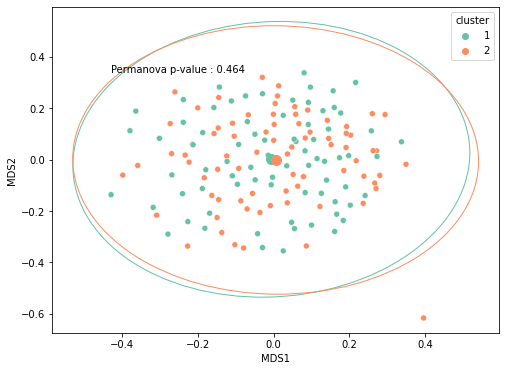

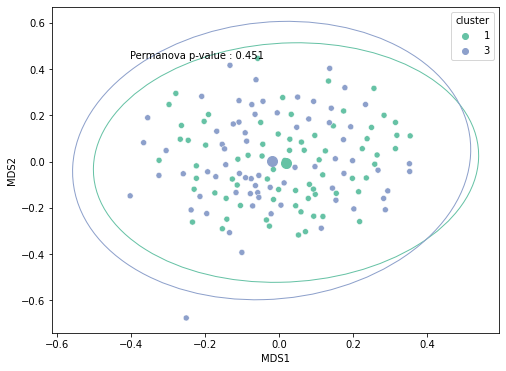

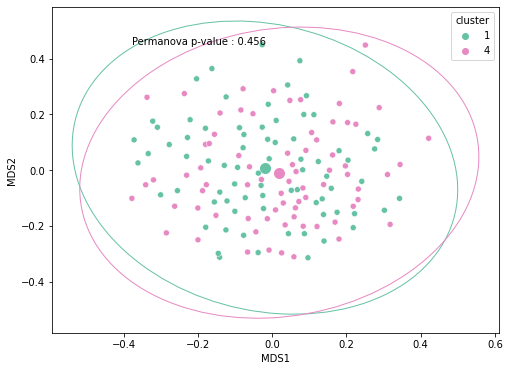

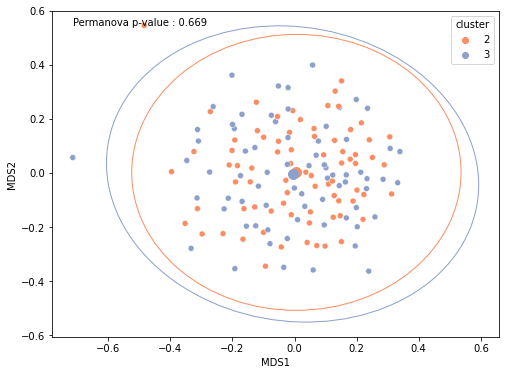

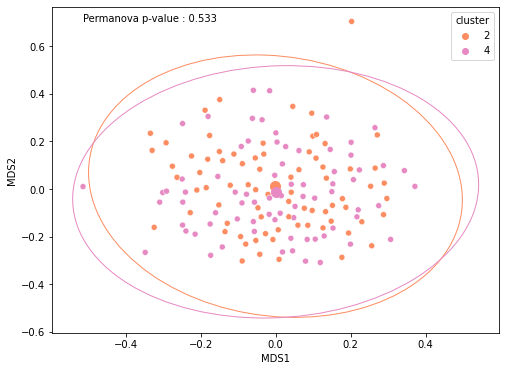

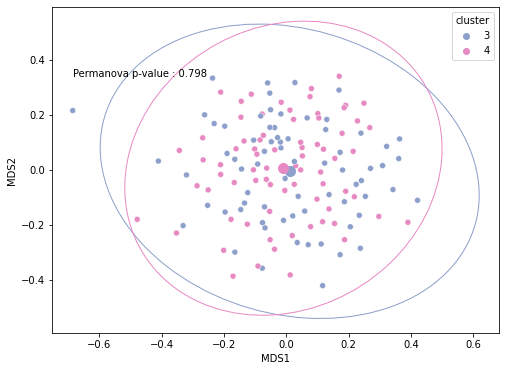

In [14]:
vs.diversity_comparison_between_cluster(hue_col='cluster',prefix='test',output_path='/home/bruce1996/repo/Microbiome_health_indicator/tmp/',ordinate_method='MDS')

In [141]:
tmp = vs.metadata.loc[vs.metadata.index,:]